In [2]:
%matplotlib inline

#各種モジュールの読み込み(tensorflowは旧バージョン)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl

/opt/anaconda3/envs/環境名　tensorflow-gpu=1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/環境名　tensorflow-gpu=1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/環境名　tensorflow-gpu=1.14/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs

In [3]:
#tensorflowにあるMNISTデータセットを読み込む
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def model_inputs(real_dim, z_dim):
    tf.disable_eager_execution()
    input_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return input_real, input_z

In [5]:
#生成器の関数を作成
def generator(z, out_dim, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_units, activation=None)
        h1 = tf.maximum(alpha * h1, h1) #Leaky ReLU
        
        logits = tf.layers.dense(h1, out_dim, activation=None)
        out = tf.tanh(logits)
        
        return out

In [6]:
#識別器の関数を作成
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_units, activation=None)
        h1 = tf.maximum(alpha*h1, h1)
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

In [7]:
# ハイパーパラメーターの初期化
input_size = 784
z_size = 100
g_hidden_size = 128
d_hidden_size = 128
alpha = 0.01
smooth = 0.1

In [8]:
tf.reset_default_graph()
input_real, input_z = model_inputs(input_size, z_size)

g_model = generator(input_z, input_size, n_units=g_hidden_size, alpha=alpha)

d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, n_units=d_hidden_size, alpha=alpha)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
#損失関数の定義
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels = tf.ones_like(d_logits_real)*(1 - smooth)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.zeros_like(d_logits_real)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels = tf.ones_like(d_logits_fake)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
#最適化の定義
learning_rate = 0.001

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

In [11]:
batch_size = 100
batch = mnist.train.next_batch(batch_size)

In [12]:
batch

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([4, 1, 1, 7, 1, 1, 9, 3, 9, 7, 1, 1, 1, 5, 5, 7, 3, 6, 4, 8, 9, 8,
        5, 9, 9, 6, 3, 7, 1, 0, 9, 9, 1, 3, 3, 9, 3, 0, 9, 9, 4, 8, 5, 9,
        7, 8, 7, 1, 6, 1, 6, 9, 1, 5, 9, 2, 9, 1, 5, 9, 0, 3, 5, 5, 6, 1,
        3, 8, 5, 8, 9, 7, 8, 5, 8, 9, 8, 9, 6, 4, 4, 9, 1, 4, 4, 0, 8, 1,
        5, 4, 7, 3, 8, 0, 0, 8, 8, 6, 1, 9], dtype=uint8))

In [13]:
batch[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
len(batch[0])

100

In [15]:
batch[0][0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [16]:
batch[1][0]

4

In [17]:
epochs = 100
samples = []
losses = []
saver = tf.train.Saver(var_list=g_vars)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images * 2 -1
            
            #Generator
            batch_z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            
            _= sess.run(d_train_optimize, feed_dict = {input_real : batch_images, input_z: batch_z})
            _= sess.run(g_train_optimize, feed_dict = {input_z : batch_z})
            
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        
        print("エポック {}/{} ".format(e+1, epochs),
              "D ロス:{:.4f} ".format(train_loss_d),
              "G ロス:{:.4f} ".format(train_loss_g))

        losses.append((train_loss_d, train_loss_g))
    
        sample_z = np.random.uniform(-1, 1, size =(16, z_size))
        gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha),feed_dict={input_z: sample_z})
    
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

with open('trainning_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

エポック 1/100  D ロス:0.3546  G ロス:3.8630 
エポック 2/100  D ロス:0.3415  G ロス:4.6054 
エポック 3/100  D ロス:0.3662  G ロス:3.8503 
エポック 4/100  D ロス:0.4943  G ロス:3.4338 
エポック 5/100  D ロス:0.4913  G ロス:6.0732 


エポック 6/100  D ロス:0.7977  G ロス:2.1148 
エポック 7/100  D ロス:0.8195  G ロス:2.5943 
エポック 8/100  D ロス:0.7369  G ロス:2.5611 
エポック 9/100  D ロス:1.2327  G ロス:2.3967 


エポック 10/100  D ロス:0.9170  G ロス:2.2177 
エポック 11/100  D ロス:1.1700  G ロス:1.5092 
エポック 12/100  D ロス:0.6560  G ロス:2.5704 
エポック 13/100  D ロス:0.7186  G ロス:3.1229 


エポック 14/100  D ロス:1.3691  G ロス:2.2047 
エポック 15/100  D ロス:0.7857  G ロス:3.5687 
エポック 16/100  D ロス:1.0739  G ロス:1.6977 
エポック 17/100  D ロス:0.9205  G ロス:2.5308 
エポック 18/100  D ロス:0.8597  G ロス:2.8186 


エポック 19/100  D ロス:1.2317  G ロス:1.8270 
エポック 20/100  D ロス:1.0797  G ロス:2.2045 
エポック 21/100  D ロス:0.6366  G ロス:3.1105 
エポック 22/100  D ロス:2.0019  G ロス:1.5077 


エポック 23/100  D ロス:1.0022  G ロス:1.5818 
エポック 24/100  D ロス:1.2620  G ロス:1.6398 
エポック 25/100  D ロス:1.7250  G ロス:1.2313 
エポック 26/100  D ロス:1.3076  G ロス:1.8913 


エポック 27/100  D ロス:1.2345  G ロス:2.3671 
エポック 28/100  D ロス:1.4311  G ロス:1.7663 
エポック 29/100  D ロス:1.1055  G ロス:1.6993 
エポック 30/100  D ロス:1.2593  G ロス:1.8007 
エポック 31/100  D ロス:1.1038  G ロス:1.4846 


エポック 32/100  D ロス:1.1291  G ロス:1.4317 
エポック 33/100  D ロス:1.0070  G ロス:2.2163 
エポック 34/100  D ロス:0.8159  G ロス:2.1135 
エポック 35/100  D ロス:1.3476  G ロス:1.3420 


エポック 36/100  D ロス:1.2565  G ロス:1.7315 
エポック 37/100  D ロス:1.6006  G ロス:1.3130 
エポック 38/100  D ロス:1.0809  G ロス:1.6489 
エポック 39/100  D ロス:0.9289  G ロス:2.7337 


エポック 40/100  D ロス:0.7609  G ロス:2.2675 
エポック 41/100  D ロス:1.0117  G ロス:1.9302 
エポック 42/100  D ロス:1.1848  G ロス:1.4520 
エポック 43/100  D ロス:0.8752  G ロス:2.1872 
エポック 44/100  D ロス:1.1193  G ロス:1.9571 


エポック 45/100  D ロス:1.0862  G ロス:1.5014 
エポック 46/100  D ロス:0.7378  G ロス:2.2179 
エポック 47/100  D ロス:0.9027  G ロス:1.7341 
エポック 48/100  D ロス:1.1427  G ロス:1.9606 


エポック 49/100  D ロス:0.9513  G ロス:2.0485 
エポック 50/100  D ロス:1.2496  G ロス:1.5246 
エポック 51/100  D ロス:0.9516  G ロス:2.1546 
エポック 52/100  D ロス:1.0536  G ロス:1.6393 


エポック 53/100  D ロス:1.0783  G ロス:1.5127 
エポック 54/100  D ロス:1.1694  G ロス:1.3941 
エポック 55/100  D ロス:1.3520  G ロス:1.5077 
エポック 56/100  D ロス:1.2945  G ロス:1.2945 
エポック 57/100  D ロス:1.1559  G ロス:1.4079 


エポック 58/100  D ロス:1.0835  G ロス:1.4129 
エポック 59/100  D ロス:1.0743  G ロス:1.8388 
エポック 60/100  D ロス:0.9213  G ロス:1.8899 
エポック 61/100  D ロス:1.0540  G ロス:1.4636 


エポック 62/100  D ロス:0.9353  G ロス:1.9861 
エポック 63/100  D ロス:0.9690  G ロス:1.6520 
エポック 64/100  D ロス:0.8471  G ロス:2.3349 
エポック 65/100  D ロス:1.0802  G ロス:1.4234 


エポック 66/100  D ロス:1.0125  G ロス:1.7608 
エポック 67/100  D ロス:1.0524  G ロス:1.7984 
エポック 68/100  D ロス:1.0414  G ロス:1.7657 
エポック 69/100  D ロス:0.9472  G ロス:1.8732 
エポック 70/100  D ロス:0.9849  G ロス:1.8238 


エポック 71/100  D ロス:0.9747  G ロス:1.8312 
エポック 72/100  D ロス:0.9135  G ロス:1.9521 
エポック 73/100  D ロス:0.9500  G ロス:1.8075 
エポック 74/100  D ロス:0.8862  G ロス:1.9773 


エポック 75/100  D ロス:0.8722  G ロス:2.1012 
エポック 76/100  D ロス:1.1189  G ロス:1.2847 
エポック 77/100  D ロス:0.9051  G ロス:1.9729 
エポック 78/100  D ロス:0.9556  G ロス:1.9067 


エポック 79/100  D ロス:0.9360  G ロス:1.9465 
エポック 80/100  D ロス:1.0143  G ロス:2.1657 
エポック 81/100  D ロス:0.8565  G ロス:1.8855 
エポック 82/100  D ロス:1.2039  G ロス:1.5185 
エポック 83/100  D ロス:0.8845  G ロス:1.6239 


エポック 84/100  D ロス:1.0220  G ロス:1.7196 
エポック 85/100  D ロス:1.1847  G ロス:1.1839 
エポック 86/100  D ロス:0.9894  G ロス:1.9875 
エポック 87/100  D ロス:0.9936  G ロス:1.4518 


エポック 88/100  D ロス:0.9757  G ロス:2.0950 
エポック 89/100  D ロス:1.0063  G ロス:1.5040 
エポック 90/100  D ロス:1.0564  G ロス:1.9538 
エポック 91/100  D ロス:1.1193  G ロス:1.4984 


エポック 92/100  D ロス:0.9979  G ロス:1.6691 
エポック 93/100  D ロス:0.9835  G ロス:1.7636 
エポック 94/100  D ロス:0.9925  G ロス:1.9156 
エポック 95/100  D ロス:0.9676  G ロス:1.5658 
エポック 96/100  D ロス:1.0266  G ロス:1.4442 


エポック 97/100  D ロス:1.0313  G ロス:1.8557 
エポック 98/100  D ロス:0.8229  G ロス:1.8604 
エポック 99/100  D ロス:0.9719  G ロス:1.6555 
エポック 100/100  D ロス:1.0281  G ロス:1.6480 


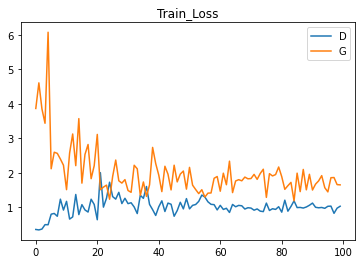

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='D')
plt.plot(losses.T[1], label='G')
plt.title('Train_Loss')
plt.legend()

## イメージに変換して表示する

In [19]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
    
    return fig, axes

In [20]:
with open('trainning_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

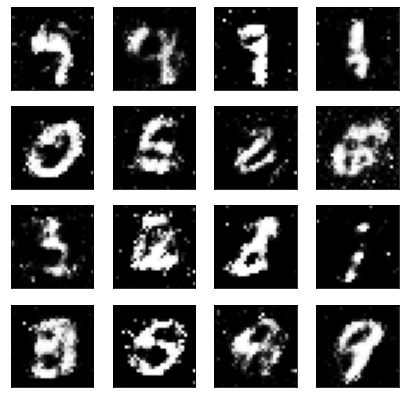

In [21]:
_ = view_samples(-1, samples)

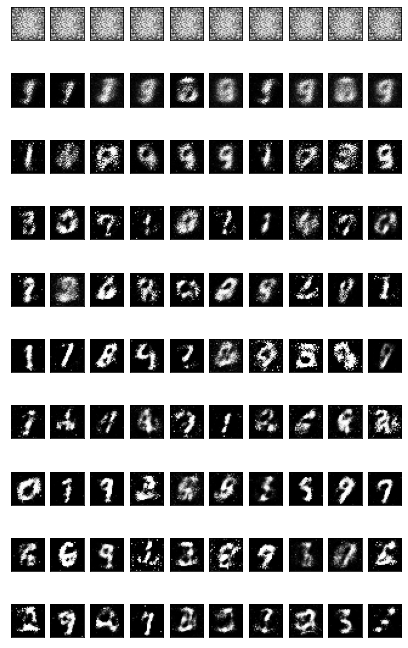

In [22]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(7, 12), nrows=rows, ncols=cols,  sharey=True, sharex=True)
for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## チェックポイントファイルから機械に画像を生成させる

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


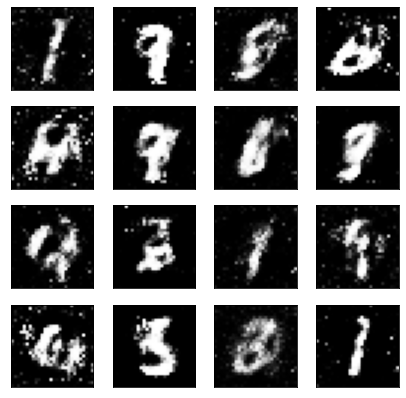

In [23]:
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    gen_samples = sess.run(generator(input_z, input_size, n_units=g_hidden_size, reuse=True, alpha=alpha), feed_dict={input_z: sample_z})

_ = view_samples(0, [gen_samples])